In [1]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "7"
torch.cuda.device_count()

1

In [2]:
from transformer_lens import HookedTransformer
from sae_lens import SAE
import torch
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

device = "cuda" if torch.cuda.is_available() else "cpu"

# get model
model = HookedTransformer.from_pretrained("google/gemma-2-2b", device = device)

layer = 15

# get the SAE for this layer
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-att-canonical",
    sae_id = f"layer_{layer}/width_16k/canonical",
    device = device
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

/proj/inductive-bias.shadow/abakalov.anaconda/envs/sae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [03:42<00:00, 74.33s/it] 


Loaded pretrained model google/gemma-2-2b into HookedTransformer
blocks.15.attn.hook_z


In [3]:
from utils.testing import get_arc_easy_accuracy

accuracy, avg_logits_diff = get_arc_easy_accuracy(model, sae.cfg.context_size, batch_size=8, dataset_split="validation")

accuracy, avg_logits_diff

71it [02:00,  1.62s/it]

torch.Size([2, 89])
{'formatted_question': ['Which device would most likely be used to produce light energy? Choose the correct answer.\nA. a microwave\nB. a toaster\nC. a radio\nD. a laser\nAnswer: ', 'Scientists at a local university have been studying the impact that people have on Earth. One of the areas being studied is how the burning of fossil fuels affects the environment. Which effect of fossil fuel burning have the scientists most likely evaluated? Choose the correct answer.\nA. the formation of acid rain\nB. the increase in runoff\nC. the production of nitrogen-fixing bacteria\nD. the mechanical weathering of roads\nAnswer: '], 'correct_label': tensor([3, 0]), 'num_labels': tensor([4, 4]), 'tokens': tensor([[     0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,     

72it [02:01,  1.68s/it]


(0.6894736842105263, 2.13550997365985)

In [4]:
from datasets import load_dataset 

dataset = load_dataset(
    "allenai/ai2_arc", "ARC-Easy",
    split="train",
    streaming=False,
)

def format_examples(examples) -> dict[str, list]:
    examples_formatted = {"sent": [],
                          "label": []}
    for example_question, example_choices, answer in zip(examples["question"], examples["choices"], examples["answerKey"]):
        have_correct_example, have_incorrect_example = False, False
        for choice, label in zip(example_choices["text"], example_choices["label"]):
            if label == answer and not have_correct_example:
                examples_formatted["sent"].append(example_question + " " + choice)
                examples_formatted["label"].append("True")
                have_correct_example = True
            elif not have_incorrect_example:
                examples_formatted["sent"].append(example_question + " " + choice)
                examples_formatted["label"].append("False")
                have_incorrect_example = True
    return examples_formatted

probing_dataset = dataset.map(format_examples, batched=True, batch_size=8, remove_columns=dataset.column_names)

print(len(probing_dataset))

probing_dataset = probing_dataset.shuffle(seed=42).select(range(500))
print(len(probing_dataset), len(probing_dataset.filter(lambda example: example["label"] == "True")))

4502
500 264


In [5]:
import numpy as np
from functools import partial

def tokenize(examples, column_name, tokenizer, max_length):
        tokenizer.padding_side = "right"
        text = examples[column_name]
        tokens = tokenizer(text, return_tensors="np", padding="longest", max_length=max_length)["input_ids"]
        len_of_input = np.argmax(tokens == tokenizer.pad_token_id, axis=1)
        assert (tokens[len_of_input == 0] != tokenizer.pad_token_id).all(), (len_of_input, tokens)
        len_of_input[len_of_input == 0] = tokens.shape[1]
        return {"tokens": tokens, "len_of_input": len_of_input}

tokenized_dataset = probing_dataset.map(
    partial(tokenize,
    column_name = "sent",
    tokenizer = model.tokenizer,
    max_length=sae.cfg.context_size),
    batched=True,
    batch_size=8,
    num_proc=None
)
tokenized_dataset.set_format(type="torch", columns=["tokens", "label", "len_of_input"])
tokenized_dataset[0]

{'label': 'False',
 'tokens': tensor([     2,  13033,   1134,   1546,   5476,    614,    573,  17930,    576,
            671,   4018,    675,    476,   2301,   6620,    578,   2910,   5182,
         235336,   3178,   5601,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]),
 'len_of_input': tensor(21)}

In [8]:
# sae.eval()

# with torch.no_grad():
#     batch_tokens = tokenized_dataset[0]["tokens"]
#     _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)

#     feature_acts = sae.encode(cache[sae.cfg.hook_name])
#     sae_out = sae.decode(feature_acts)

#     del cache
#     l0 = (feature_acts[:, 1:] > 0).float().sum(-1).detach()
#     print("average l0", l0.mean().item())

average l0 81.35897827148438


In [48]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

accuracies = []
num_of_features = []
for layer in range(0, 25):
    # get the SAE for this layer
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-att-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )

    # get hook point
    hook_point = sae.cfg.hook_name

    sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

    correct_activations = []

    dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch_tokens = batch["tokens"]
            _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)

            feature_acts = sae.encode(cache[sae.cfg.hook_name])
            correct_activations.append(feature_acts[np.arange(batch_tokens.shape[0]), batch["len_of_input"] - 1, :].detach().cpu())

            del cache

    correct_activations_dataset = torch.vstack(correct_activations)

    X = correct_activations_dataset.numpy()
    y = np.array([1 if item["label"] == "True" else -1 for item in tokenized_dataset])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    lr = LogisticRegression(penalty="l1", solver="liblinear").fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    num_of_features.append((lr.coef_ != 0).sum())

100%|██████████| 63/63 [00:35<00:00,  1.79it/s]


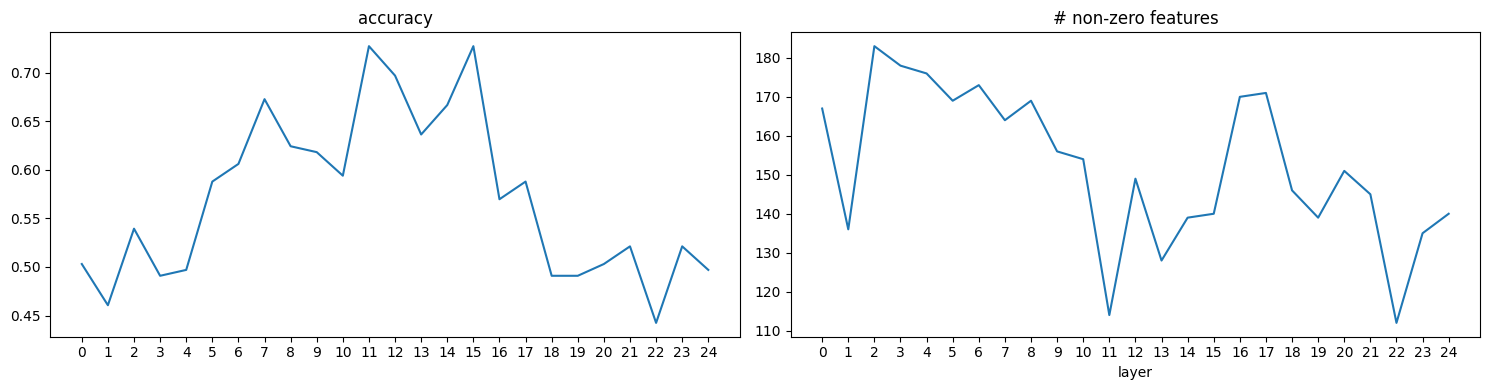

In [50]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
fig.set_size_inches((15, 4))
axs[0].plot(accuracies)
axs[0].set_title("accuracy")

axs[1].plot(num_of_features)
axs[1].set_title("# non-zero features")

for i in range(2):
    axs[i].set_xticks(np.arange(len(accuracies)), labels=np.arange(len(accuracies)))
    if i == 1:
        axs[i].set_xlabel("layer")
fig.tight_layout()
plt.savefig("probing_accuracy_attn.png");

In [51]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

accuracies_mlp = []
num_of_features_mlp = []
for layer in range(0, 25):
    # get the SAE for this layer
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-mlp-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )

    # get hook point
    hook_point = sae.cfg.hook_name

    sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

    correct_activations = []

    dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch_tokens = batch["tokens"]
            _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)

            feature_acts = sae.encode(cache[sae.cfg.hook_name])
            correct_activations.append(feature_acts[np.arange(batch_tokens.shape[0]), batch["len_of_input"] - 1, :].detach().cpu())

            del cache

    correct_activations_dataset = torch.vstack(correct_activations)

    X = correct_activations_dataset.numpy()
    y = np.array([1 if item["label"] == "True" else -1 for item in tokenized_dataset])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    lr = LogisticRegression(penalty="l1", solver="liblinear").fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    accuracies_mlp.append(accuracy_score(y_test, y_pred))
    num_of_features_mlp.append((lr.coef_ != 0).sum())

100%|██████████| 63/63 [00:38<00:00,  1.62it/s]


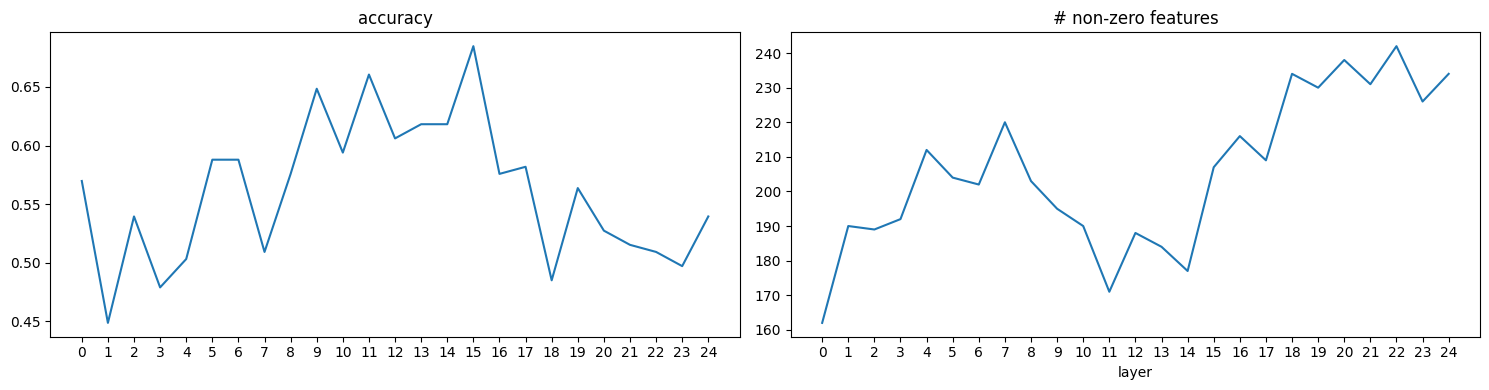

In [55]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
fig.set_size_inches((15, 4))
axs[0].plot(accuracies_mlp)
axs[0].set_title("accuracy")

axs[1].plot(num_of_features_mlp)
axs[1].set_title("# non-zero features")

for i in range(2):
    axs[i].set_xticks(np.arange(len(accuracies)), labels=np.arange(len(accuracies)))
    if i == 1:
        axs[i].set_xlabel("layer")
fig.tight_layout()
plt.savefig("probing_accuracy_mlp.png");

In [86]:
from importlib import reload
import utils.steering
import utils.get_steering_vector
import utils.dataset
import utils.testing

# reload(utils.get_steering_vector)
reload(utils.steering)
# reload(utils.dataset)
# reload(utils.testing)

<module 'utils.steering' from '/project/inductive-bias/llama/sae/utils/steering.py'>

In [6]:
# [layer for layer in range(len(accuracies)) if accuracies[layer] > 0.65]

attn_layers_to_invade = [7, 11, 12, 14, 15]

In [7]:
# [layer for layer in range(len(accuracies)) if accuracies_mlp[layer] > 0.65]

mlp_layers_to_invade = [11, 15]

In [77]:
layers_to_invade_attn = [layer for layer in range(len(accuracies)) if accuracies[layer] > 0.65]

In [8]:
from utils.get_steering_vector import get_steering_vectors_lr_and_mean_diff

Xs_difference, lrs, hook_names = get_steering_vectors_lr_and_mean_diff(model=model, layers_to_invade=attn_layers_to_invade,
                                                                       device="cuda",
                                                                       tokenized_dataset=tokenized_dataset, batch_size=8, type_of_activation="att")

100%|██████████| 5/5 [03:22<00:00, 40.50s/it]


In [9]:
from utils.get_steering_vector import get_steering_vectors_lr_and_mean_diff

Xs_difference_mlp, lrs_mlp, hook_names_mlp = get_steering_vectors_lr_and_mean_diff(model=model, layers_to_invade=mlp_layers_to_invade,
                                                                       device="cuda",
                                                                       tokenized_dataset=tokenized_dataset, batch_size=8, type_of_activation="mlp")

100%|██████████| 2/2 [01:16<00:00, 38.13s/it]


In [26]:
from utils.get_steering_vector import get_steering_vectors_lr_and_mean_diff

res_layers_to_invade = [9, 10, 11, 13, 15]
Xs_difference_res, lrs_res, hook_names_res = get_steering_vectors_lr_and_mean_diff(model=model, layers_to_invade=res_layers_to_invade,
                                                                       device="cuda",
                                                                       tokenized_dataset=tokenized_dataset, batch_size=8, type_of_activation="res")

100%|██████████| 5/5 [04:18<00:00, 51.77s/it]


In [27]:
# np.argsort(-Xs_difference_res[0])[:10]
# 964: point,
# 1435: licence
# 13081: many things
# 15550: something about the task structure, terms related to military or geological contexts and measurements
# 3919: many things, contexts related to dietary habits and health effects
# 12490: bos token, induction head?, structured coding patterns or programming syntax
# 6931: checical reactions
# 8686: sun,
# 12856: descriptions of processes involving technology and improvements in methodologies
# 8379: concepts related to energy, work, and thermodynamics in physical systems:

[  964,  1435, 13081, 15550,  3919, 12490,  6931,  8686, 12856, 8379]

array([  964,  1435, 13081, 15550,  3919, 12490,  6931,  8686, 12856,
        8379])

In [34]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks
steering_vectors = []
# for activation_vector, layer in zip(Xs_difference, attn_layers_to_invade):
#     sae, cfg_dict, _ = SAE.from_pretrained(
#         release = "gemma-scope-2b-pt-att-canonical",
#         sae_id = f"layer_{layer}/width_16k/canonical",
#         device = device
#     )
#     features = activation_vector.nonzero()[0]
#     steering_vector = sum([sae.W_dec[feature] * coef for feature, coef in zip(features, activation_vector[activation_vector.nonzero()[0]])])
#     steering_vectors.append(steering_vector)

steering_vectors_mlp = []
# for activation_vector, layer in zip(Xs_difference_mlp, mlp_layers_to_invade):
#     sae, cfg_dict, _ = SAE.from_pretrained(
#         release = "gemma-scope-2b-pt-mlp-canonical",
#         sae_id = f"layer_{layer}/width_16k/canonical",
#         device = device
#     )
#     features = activation_vector.nonzero()[0]
#     steering_vector = sum([sae.W_dec[feature] * coef for feature, coef in zip(features, activation_vector[activation_vector.nonzero()[0]])])
#     steering_vectors_mlp.append(steering_vector)

steering_vectors_res = []
for activation_vector, layer in zip(Xs_difference_res, res_layers_to_invade):
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )
    features = np.argsort(-activation_vector)[:10]
    # coefs = -np.sort(-activation_vector)
    steering_vector = sum([sae.W_dec[feature] for feature in features])
    steering_vectors_res.append(steering_vector)
    break

evaluated = []
for strength in np.linspace(0, 1, 5):
    steering_strengths = [strength for _ in range(len(steering_vectors) + len(steering_vectors_mlp) + len(steering_vectors_res))]
    res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=hook_names+hook_names_mlp+hook_names_res, sae_context_size=1024,
                batch_size=8, dataset_split="validation", steering_vectors=steering_vectors+steering_vectors_mlp+steering_vectors_res,
                steering_strengths=steering_strengths)
    print(strength, res)
    evaluated.append(res)
evaluated

72it [02:38,  2.20s/it]


0.0 (0.6894736842105263, 2.13550997365985)


72it [01:44,  1.45s/it]


0.25 (0.6912280701754386, 2.1384756749136407)


72it [01:51,  1.55s/it]


0.5 (0.6912280701754386, 2.13833211932266)


72it [01:46,  1.47s/it]


0.75 (0.6912280701754386, 2.135095766970986)


72it [01:43,  1.43s/it]

1.0 (0.6929824561403509, 2.1285350046659772)


[(0.6894736842105263, 2.13550997365985),
 (0.6912280701754386, 2.1384756749136407),
 (0.6912280701754386, 2.13833211932266),
 (0.6912280701754386, 2.135095766970986),
 (0.6929824561403509, 2.1285350046659772)]

In [28]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks
steering_vectors = []
# for activation_vector, layer in zip(Xs_difference, attn_layers_to_invade):
#     sae, cfg_dict, _ = SAE.from_pretrained(
#         release = "gemma-scope-2b-pt-att-canonical",
#         sae_id = f"layer_{layer}/width_16k/canonical",
#         device = device
#     )
#     features = activation_vector.nonzero()[0]
#     steering_vector = sum([sae.W_dec[feature] * coef for feature, coef in zip(features, activation_vector[activation_vector.nonzero()[0]])])
#     steering_vectors.append(steering_vector)

steering_vectors_mlp = []
# for activation_vector, layer in zip(Xs_difference_mlp, mlp_layers_to_invade):
#     sae, cfg_dict, _ = SAE.from_pretrained(
#         release = "gemma-scope-2b-pt-mlp-canonical",
#         sae_id = f"layer_{layer}/width_16k/canonical",
#         device = device
#     )
#     features = activation_vector.nonzero()[0]
#     steering_vector = sum([sae.W_dec[feature] * coef for feature, coef in zip(features, activation_vector[activation_vector.nonzero()[0]])])
#     steering_vectors_mlp.append(steering_vector)

steering_vectors_res = []
for activation_vector, layer in zip(Xs_difference_res, res_layers_to_invade):
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )
    features = np.argsort(-activation_vector)[:10]
    coefs = -np.sort(-activation_vector)[:10]
    steering_vector = sum([sae.W_dec[feature] * coef for feature, coef in zip(features, coefs)])
    steering_vectors_res.append(steering_vector)

evaluated = []
for strength in np.linspace(0, 1, 5):
    steering_strengths = [strength for _ in range(len(steering_vectors) + len(steering_vectors_mlp) + len(steering_vectors_res))]
    res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=hook_names+hook_names_mlp+hook_names_res, sae_context_size=1024,
                batch_size=8, dataset_split="validation", steering_vectors=steering_vectors+steering_vectors_mlp+steering_vectors_res,
                steering_strengths=steering_strengths)
    print(strength, res)
    evaluated.append(res)
evaluated

72it [01:41,  1.41s/it]


0.0 (0.6894736842105263, 2.13550997365985)


72it [01:41,  1.42s/it]


0.25 (0.6947368421052632, 2.1254652910065235)


72it [01:38,  1.37s/it]


0.5 (0.6894736842105263, 2.0996636733674165)


72it [01:37,  1.36s/it]


0.75 (0.6929824561403509, 2.059404564740365)


72it [01:28,  1.23s/it]

1.0 (0.6929824561403509, 2.0042639493942263)


[(0.6894736842105263, 2.13550997365985),
 (0.6947368421052632, 2.1254652910065235),
 (0.6894736842105263, 2.0996636733674165),
 (0.6929824561403509, 2.059404564740365),
 (0.6929824561403509, 2.0042639493942263)]

In [71]:
Xs_difference[0].nonzero()[0]

(4770,)

In [10]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks
steering_vectors = []
for activation_vector, layer in zip(Xs_difference, attn_layers_to_invade):
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-att-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )
    features = activation_vector.nonzero()[0]
    steering_vector = sum([sae.W_dec[feature] * coef for feature, coef in zip(features, activation_vector[activation_vector.nonzero()[0]])])
    steering_vectors.append(steering_vector)

steering_vectors_mlp = []
for activation_vector, layer in zip(Xs_difference_mlp, mlp_layers_to_invade):
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-mlp-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )
    features = activation_vector.nonzero()[0]
    steering_vector = sum([sae.W_dec[feature] * coef for feature, coef in zip(features, activation_vector[activation_vector.nonzero()[0]])])
    steering_vectors_mlp.append(steering_vector)

evaluated = []
for strength in np.linspace(0, 1, 5):
    steering_strengths = [strength for _ in range(len(steering_vectors) + len(steering_vectors_mlp))]
    res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=hook_names+hook_names_mlp, sae_context_size=1024,
                batch_size=8, dataset_split="validation", steering_vectors=steering_vectors+steering_vectors_mlp, steering_strengths=steering_strengths)
    print(strength, res)
    evaluated.append(res)
evaluated

72it [01:08,  1.05it/s]


0.0 (0.6894736842105263, 2.13550997365985)


72it [01:03,  1.13it/s]


0.25 (0.6912280701754386, 2.137697009872972)


72it [00:54,  1.31it/s]


0.5 (0.6929824561403509, 2.1358905122991194)


72it [00:53,  1.34it/s]


0.75 (0.6947368421052632, 2.130352436868768)


72it [00:52,  1.38it/s]

1.0 (0.6964912280701754, 2.1209033045852395)


[(0.6894736842105263, 2.13550997365985),
 (0.6912280701754386, 2.137697009872972),
 (0.6929824561403509, 2.1358905122991194),
 (0.6947368421052632, 2.130352436868768),
 (0.6964912280701754, 2.1209033045852395)]

In [20]:
np.argsort(-Xs_difference[0])[:40]

array([ 3812,  3126,  5790,  3005,  1205,  3505,  5201,  1754,  3145,
       14417,  8489,  1948,  8658, 11687,  1217,  7584,  6027,  3987,
       13394,  7063, 13799, 11956,  7528,  7957,  1856, 14067,  1725,
        2714,  6748,  4291,  8608, 13652, 15216,  1324, 16061,  2561,
       13470,  4129, 15416,  5603])

In [18]:
attn_layers_to_invade[0]

7

In [ ]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks
top_k = 100

steering_vectors = []
for activation_vector, layer in zip(Xs_difference, attn_layers_to_invade):
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-att-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )
    features = np.argsort(-activation_vector)[:top_k]
    steering_vector = sum([sae.W_dec[feature] for feature in features])
    steering_vectors.append(steering_vector)

steering_vectors_mlp = []
# for activation_vector, layer in zip(Xs_difference_mlp, mlp_layers_to_invade):
#     sae, cfg_dict, _ = SAE.from_pretrained(
#         release = "gemma-scope-2b-pt-mlp-canonical",
#         sae_id = f"layer_{layer}/width_16k/canonical",
#         device = device
#     )
#     features = activation_vector.nonzero()[0]
#     steering_vector = sum([sae.W_dec[feature] for feature, coef in zip(features, activation_vector[activation_vector.nonzero()[0]])])
#     steering_vectors_mlp.append(steering_vector)

evaluated = []
for strength in np.linspace(0, 1, 5):
    steering_strengths = [strength for _ in range(len(steering_vectors) + len(steering_vectors_mlp))]
    res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=hook_names+hook_names_mlp, sae_context_size=1024,
                batch_size=8, dataset_split="validation", steering_vectors=steering_vectors+steering_vectors_mlp, steering_strengths=steering_strengths)
    print(strength, res)
    evaluated.append(res)
evaluated

In [35]:
from importlib import reload
import utils.steering
import utils.get_steering_vector
import utils.dataset
import utils.testing

# reload(utils.get_steering_vector)

reload(utils.steering)
# reload(utils.dataset)
# reload(utils.testing)

<module 'utils.steering' from '/project/inductive-bias/llama/sae/utils/steering.py'>

In [6]:
# from tqdm import tqdm
# from torch.utils.data import DataLoader
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# import numpy as np

# accuracies = {
#     "l1": [],
#     "l2": []
# }
# num_of_features = {
#     "l1": [],
#     "l2": []
# }
# for layer in range(0, 25):
#     # get the SAE for this layer
#     sae, cfg_dict, _ = SAE.from_pretrained(
#         release = "gemma-scope-2b-pt-res-canonical",
#         sae_id = f"layer_{layer}/width_16k/canonical",
#         device = device
#     )

#     # get hook point
#     hook_point = sae.cfg.hook_name

#     sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

#     correct_activations = []

#     dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False)

#     with torch.no_grad():
#         for batch in tqdm(dataloader):
#             batch_tokens = batch["tokens"]
#             _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)

#             feature_acts = sae.encode(cache[sae.cfg.hook_name])
#             correct_activations.append(feature_acts[np.arange(batch_tokens.shape[0]), batch["len_of_input"] - 1, :].detach().cpu())

#             del cache

#     correct_activations_dataset = torch.vstack(correct_activations)

#     X = correct_activations_dataset.numpy()
#     y = np.array([1 if item["label"] == "True" else -1 for item in tokenized_dataset])

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#     lr = LogisticRegression(penalty="l1", solver="liblinear").fit(X_train, y_train)
#     y_pred = lr.predict(X_test)
#     accuracies["l1"].append(accuracy_score(y_test, y_pred))
#     num_of_features["l1"].append((lr.coef_ != 0).sum())

#     lr = LogisticRegression(penalty="l2").fit(X_train, y_train)
#     y_pred = lr.predict(X_test)
#     accuracies["l2"].append(accuracy_score(y_test, y_pred))
#     num_of_features["l2"].append((lr.coef_ != 0).sum())

100%|██████████| 63/63 [00:17<00:00,  3.57it/s]
/proj/inductive-bias.shadow/abakalov.anaconda/envs/sae/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 63/63 [00:18<00:00,  3.42it/s]
/proj/inductive-bias.shadow/abakalov.anaconda/envs/sae/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

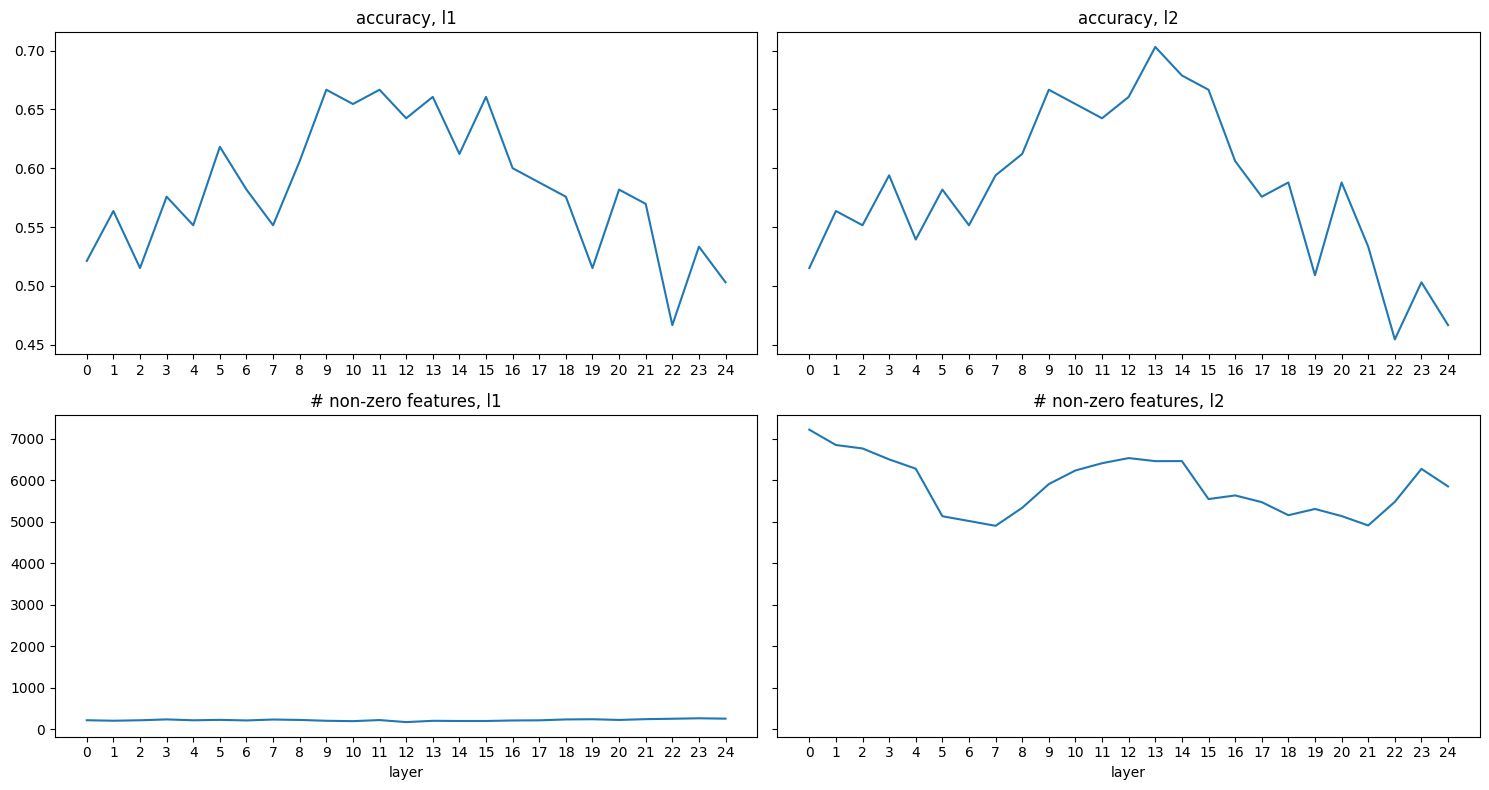

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, sharey="row")
fig.set_size_inches((15, 8))
axs[0][0].plot(accuracies["l1"])
axs[0][0].set_title("accuracy, l1")

axs[0][1].plot(accuracies["l2"])
axs[0][1].set_title("accuracy, l2")

axs[1][0].plot(num_of_features["l1"])
axs[1][0].set_title("# non-zero features, l1")

axs[1][1].plot(num_of_features["l2"])
axs[1][1].set_title("# non-zero features, l2")

for i in range(2):
    for j in range(2):
        axs[i][j].set_xticks(np.arange(len(accuracies["l1"])), labels=np.arange(len(accuracies["l1"])))
        if i == 1:
            axs[i][j].set_xlabel("layer")
fig.tight_layout()
plt.savefig("probing_accuracy.png");

In [5]:
from utils.steering import get_lr_coefs

layer = 10

# get the SAE for this layer
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-res-canonical",
    sae_id = f"layer_{layer}/width_16k/canonical",
    device = device
)

lr = get_lr_coefs(batch_size=8, tokenized_dataset=tokenized_dataset, sae=sae, model=model)

100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


In [50]:
for thres in np.logspace(-1, 0, 10):
    print(thres, (lr.coef_ > thres).sum())

0.09999999999999999 54
0.1291549665014884 37
0.16681005372000587 29
0.21544346900318834 18
0.2782559402207124 10
0.35938136638046275 6
0.46415888336127786 3
0.5994842503189408 3
0.7742636826811269 0
1.0 0


In [79]:
for thres in [0.1, 0.12, 0.15, 0.17, 0.2, 0.3, 0.4, 0.5, 0.7]:
    print(thres, (lr.coef_ > thres).sum())

0.1 54
0.12 42
0.15 33
0.17 26
0.2 19
0.3 8
0.4 5
0.5 3
0.7 1


In [18]:
from importlib import reload
import utils.steering
import utils.dataset
import utils.testing

reload(utils.steering)
reload(utils.dataset)
reload(utils.testing)

<module 'utils.testing' from '/project/inductive-bias/llama/sae/utils/testing.py'>

In [84]:
from utils.steering import generate_with_steering, find_max_activation
thres = (lr.coef_ > 0.3).sum()
print(thres)
features_to_steer = np.argsort(-lr.coef_)[0, :thres]
print(features_to_steer)
steering_strengths = [-1.0 for i in range(len(features_to_steer))]
max_acts = [1.0 for i in range(len(features_to_steer))]
# find_max_activation(model, sae, tokenized_dataset, features_to_steer, batch_size=8) # [1.0 for i in range(len(features_to_steer))]
pos_to_intervene=[-1]

prompt="Is the Earth flat?"

answer = generate_with_steering(model, sae, prompt, steering_features=features_to_steer, max_acts=max_acts,
                       steering_strengths=steering_strengths, pos_to_intervene=pos_to_intervene, max_new_tokens=95)
print(answer)

8
[ 5623  7296  6875  5835 16152  5276 11141 13198]


100%|██████████| 95/95 [00:08<00:00, 10.70it/s]

<bos>Is the Earth flat?

[User 0001]

Is the Earth flat or is it a sphere?

This is a very old question that I've always had a hard time getting a definitive answer to.

In 1923, I was told that the Earth was a sphere by a teacher in a private school, and this was what I believed for years.

Then, in 1999, I read a book written by a man named


In [9]:
# from utils.steering import get_arc_easy_accuracy_with_steering

# thres = (lr.coef_ > 0.3).sum()
# print(thres)
# features_to_steer = np.argsort(-lr.coef_)[0, :thres]
# print(features_to_steer)

# evaluated = []
# for strength in np.linspace(-10, 10, 20):
#     steering_strengths = [strength for i in range(len(features_to_steer))]
#     max_acts = [1.0 for i in range(len(features_to_steer))]
#     pos_to_intervene=[-1]

#     res = get_arc_easy_accuracy_with_steering(model, sae, batch_size=8, dataset_split="train",
#                                               steering_features=features_to_steer, max_acts=max_acts, steering_strengths=steering_strengths)
#     print(strength, res)
#     evaluated.append(res)
# evaluated

# evaluated = [(0.7014660151043981, 2.089265980544698),
#  (0.70501999111506, 2.123991856941484),
#  (0.7063527321190582, 2.1566727971670523),
#  (0.7099067081297201, 2.1872632171990127),
#  (0.7156819191470457, 2.215828208804713),
#  (0.7210128831630387, 2.2426263022454567),
#  (0.7214571301643714, 2.2676377260436062),
#  (0.7196801421590404, 2.290717995998225),
#  (0.7192358951577077, 2.312035222945347),
#  (0.7214571301643714, 2.3314149687947934),
#  (0.7219013771657041, 2.3487465607224967),
#  (0.7227898711683696, 2.363635439387643),
#  (0.7241226121723678, 2.375791412626357),
#  (0.7254553531763661, 2.3846282573447444),
#  (0.727232341181697, 2.3901396916210254),
#  (0.7267880941803643, 2.392210663397648),
#  (0.7267880941803643, 2.3902471634294127),
#  (0.7267880941803643, 2.384108913680915),
#  (0.7250111061750333, 2.3742192406910676),
#  (0.7263438471790316, 2.3608515454313057)]

8
[ 5623  7296  6875  5835 16152  5276 11141 13198]


282it [03:13,  1.46it/s]


-10.0 (0.7014660151043981, 2.089265980544698)


282it [03:15,  1.44it/s]


-8.947368421052632 (0.70501999111506, 2.123991856941484)


282it [03:14,  1.45it/s]


-7.894736842105264 (0.7063527321190582, 2.1566727971670523)


282it [03:13,  1.46it/s]


-6.842105263157895 (0.7099067081297201, 2.1872632171990127)


282it [03:13,  1.46it/s]


-5.7894736842105265 (0.7156819191470457, 2.215828208804713)


282it [03:13,  1.46it/s]


-4.736842105263158 (0.7210128831630387, 2.2426263022454567)


282it [03:13,  1.46it/s]


-3.6842105263157894 (0.7214571301643714, 2.2676377260436062)


282it [03:13,  1.46it/s]


-2.6315789473684212 (0.7196801421590404, 2.290717995998225)


282it [03:12,  1.46it/s]


-1.578947368421053 (0.7192358951577077, 2.312035222945347)


282it [03:12,  1.46it/s]


-0.526315789473685 (0.7214571301643714, 2.3314149687947934)


282it [03:12,  1.46it/s]


0.5263157894736832 (0.7219013771657041, 2.3487465607224967)


282it [03:12,  1.46it/s]


1.5789473684210513 (0.7227898711683696, 2.363635439387643)


282it [03:12,  1.47it/s]


2.6315789473684212 (0.7241226121723678, 2.375791412626357)


282it [03:11,  1.47it/s]


3.6842105263157894 (0.7254553531763661, 2.3846282573447444)


282it [03:11,  1.47it/s]


4.7368421052631575 (0.727232341181697, 2.3901396916210254)


282it [03:11,  1.47it/s]


5.789473684210526 (0.7267880941803643, 2.392210663397648)


282it [03:13,  1.46it/s]


6.842105263157894 (0.7267880941803643, 2.3902471634294127)


282it [03:13,  1.46it/s]


7.894736842105264 (0.7267880941803643, 2.384108913680915)


282it [03:12,  1.47it/s]


8.94736842105263 (0.7250111061750333, 2.3742192406910676)


282it [03:12,  1.47it/s]

10.0 (0.7263438471790316, 2.3608515454313057)


[(0.7014660151043981, 2.089265980544698),
 (0.70501999111506, 2.123991856941484),
 (0.7063527321190582, 2.1566727971670523),
 (0.7099067081297201, 2.1872632171990127),
 (0.7156819191470457, 2.215828208804713),
 (0.7210128831630387, 2.2426263022454567),
 (0.7214571301643714, 2.2676377260436062),
 (0.7196801421590404, 2.290717995998225),
 (0.7192358951577077, 2.312035222945347),
 (0.7214571301643714, 2.3314149687947934),
 (0.7219013771657041, 2.3487465607224967),
 (0.7227898711683696, 2.363635439387643),
 (0.7241226121723678, 2.375791412626357),
 (0.7254553531763661, 2.3846282573447444),
 (0.727232341181697, 2.3901396916210254),
 (0.7267880941803643, 2.392210663397648),
 (0.7267880941803643, 2.3902471634294127),
 (0.7267880941803643, 2.384108913680915),
 (0.7250111061750333, 2.3742192406910676),
 (0.7263438471790316, 2.3608515454313057)]

In [6]:
# from utils.steering import get_arc_easy_accuracy_with_steering

# thres = (lr.coef_ > 0.3).sum()
# print(thres)
# features_to_steer = np.argsort(-lr.coef_)[0, :thres]
# print(features_to_steer)

# evaluated = []
# for strength in np.linspace(-50, 50, 10):
#     steering_strengths = [strength for i in range(len(features_to_steer))]
#     max_acts = [1.0 for i in range(len(features_to_steer))]
#     pos_to_intervene=[-1]

#     res = get_arc_easy_accuracy_with_steering(model, sae, batch_size=8, dataset_split="train",
#                                               steering_features=features_to_steer, max_acts=max_acts, steering_strengths=steering_strengths)
#     print(strength, res)
#     evaluated.append(res)
# evaluated

# evaluated = [(0.5784095957352288, 0.32702597889673546),
#  (0.58996001776988, 0.639232947316926),
#  (0.6303864948911595, 1.263081091766832),
#  (0.6796979120390937, 1.8140758936376584),
#  (0.7165704131497113, 2.221932182837359),
#  (0.727232341181697, 2.3920685593576656),
#  (0.7227898711683696, 2.2141150341516918),
#  (0.7005775211017325, 1.8333886024529327),
#  (0.6414926699244781, 1.2643946201099072),
#  (0.5824078187472235, 0.7404913972187762)]

8
[ 5623  7296  6875  5835 16152  5276 11141 13198]


58it [00:41,  1.49it/s]

282it [03:14,  1.45it/s]


-50.0 (0.5784095957352288, 0.32702597889673546)


282it [03:15,  1.44it/s]


-38.888888888888886 (0.58996001776988, 0.639232947316926)


282it [03:15,  1.44it/s]


-27.77777777777778 (0.6303864948911595, 1.263081091766832)


282it [03:15,  1.44it/s]


-16.66666666666667 (0.6796979120390937, 1.8140758936376584)


282it [03:15,  1.45it/s]


-5.555555555555557 (0.7165704131497113, 2.221932182837359)


282it [03:13,  1.46it/s]


5.555555555555557 (0.727232341181697, 2.3920685593576656)


282it [03:13,  1.46it/s]


16.666666666666657 (0.7227898711683696, 2.2141150341516918)


282it [03:12,  1.46it/s]


27.77777777777777 (0.7005775211017325, 1.8333886024529327)


282it [03:13,  1.46it/s]


38.888888888888886 (0.6414926699244781, 1.2643946201099072)


282it [03:14,  1.45it/s]

50.0 (0.5824078187472235, 0.7404913972187762)


[(0.5784095957352288, 0.32702597889673546),
 (0.58996001776988, 0.639232947316926),
 (0.6303864948911595, 1.263081091766832),
 (0.6796979120390937, 1.8140758936376584),
 (0.7165704131497113, 2.221932182837359),
 (0.727232341181697, 2.3920685593576656),
 (0.7227898711683696, 2.2141150341516918),
 (0.7005775211017325, 1.8333886024529327),
 (0.6414926699244781, 1.2643946201099072),
 (0.5824078187472235, 0.7404913972187762)]

In [7]:
for thres in [0.1, 0.12, 0.15, 0.17, 0.2, 0.3, 0.4, 0.5, 0.7]:
    print(thres, (lr.coef_ > thres).sum())

0.1 54
0.12 42
0.15 33
0.17 26
0.2 19
0.3 8
0.4 5
0.5 3
0.7 1


In [8]:
# from utils.steering import get_arc_easy_accuracy_with_steering

# thres = (lr.coef_ > 0.1).sum()
# print(thres)
# features_to_steer = np.argsort(-lr.coef_)[0, :thres]
# print(features_to_steer)

# evaluated = []
# for strength in np.linspace(-5, 5, 10):
#     steering_strengths = [strength for i in range(len(features_to_steer))]
#     max_acts = [1.0 for i in range(len(features_to_steer))]
#     pos_to_intervene=[-1]

#     res = get_arc_easy_accuracy_with_steering(model, sae, batch_size=8, dataset_split="train",
#                                               steering_features=features_to_steer, max_acts=max_acts, steering_strengths=steering_strengths)
#     print(strength, res)
#     evaluated.append(res)
# evaluated

# evaluated=[(0.6943580630830742, 1.8434110742735894),
#  (0.7023545091070635, 1.9680671681302857),
#  (0.7099067081297201, 2.0846291764054707),
#  (0.7147934251443803, 2.195053511542884),
#  (0.7183474011550423, 2.295129239214944),
#  (0.7245668591737006, 2.381197883202626),
#  (0.729009329187028, 2.4436962126838213),
#  (0.729009329187028, 2.476058737112119),
#  (0.727232341181697, 2.4720052281044578),
#  (0.7298978231896934, 2.427765589298433)]

54
[ 5623  7296  6875  5835 16152  5276 11141 13198 13971   165  9148  7081
  7028 13025 14674 13991  2969 15637 14833 10762  4649 14927  9958  8881
 12193  8705 14614 13401  1805 15795 12892 16370   691  4348 11929   840
 13863  3658  8389 10931  5019 10927  3484 13176 12154  4082 12822  8266
  7274  5013  1967 12484 12748 12865]


282it [03:24,  1.38it/s]


-5.0 (0.6943580630830742, 1.8434110742735894)


282it [03:20,  1.40it/s]


-3.888888888888889 (0.7023545091070635, 1.9680671681302857)


282it [03:20,  1.41it/s]


-2.7777777777777777 (0.7099067081297201, 2.0846291764054707)


282it [03:20,  1.40it/s]


-1.6666666666666665 (0.7147934251443803, 2.195053511542884)


282it [03:24,  1.38it/s]


-0.5555555555555554 (0.7183474011550423, 2.295129239214944)


282it [03:24,  1.38it/s]


0.5555555555555554 (0.7245668591737006, 2.381197883202626)


282it [03:22,  1.39it/s]


1.666666666666667 (0.729009329187028, 2.4436962126838213)


282it [03:22,  1.39it/s]


2.7777777777777786 (0.729009329187028, 2.476058737112119)


282it [03:21,  1.40it/s]


3.8888888888888893 (0.727232341181697, 2.4720052281044578)


282it [03:21,  1.40it/s]

5.0 (0.7298978231896934, 2.427765589298433)


[(0.6943580630830742, 1.8434110742735894),
 (0.7023545091070635, 1.9680671681302857),
 (0.7099067081297201, 2.0846291764054707),
 (0.7147934251443803, 2.195053511542884),
 (0.7183474011550423, 2.295129239214944),
 (0.7245668591737006, 2.381197883202626),
 (0.729009329187028, 2.4436962126838213),
 (0.729009329187028, 2.476058737112119),
 (0.727232341181697, 2.4720052281044578),
 (0.7298978231896934, 2.427765589298433)]

In [24]:
-np.sort(-lr.coef_[0])

array([ 0.77366947,  0.67713568,  0.61617617, ..., -0.51298628,
       -0.51988048, -0.60010548])

In [11]:
sorted(-lr.coef_)

[array([-0., -0., -0., ..., -0., -0., -0.])]

In [27]:
# from utils.steering import get_arc_easy_accuracy_with_steering

# thres = (lr.coef_ > 0.1).sum()
# print(thres)
# features_to_steer = np.argsort(-lr.coef_)[0, :thres]
# print(features_to_steer)
# coefs_to_add_features = -np.sort(-lr.coef_[0])[:thres]
# print(coefs_to_add_features)
# steering_vectors = [sae.W_dec[steering_feature] for steering_feature in features_to_steer]
# steering_vector = sum([feature * coef for feature, coef in zip(steering_vectors, coefs_to_add_features)])
# print(steering_vector)

# evaluated = []
# for strength in np.linspace(-5, 5, 10):
#     steering_strengths = [strength]
#     max_acts = [1.0]

#     res = get_arc_easy_accuracy_with_steering(model, sae, batch_size=8, dataset_split="train",
#                                               steering_vectors=[steering_vector], max_acts=max_acts, steering_strengths=steering_strengths)
#     print(strength, res)
#     evaluated.append(res)
# evaluated = [(0.7174589071523767, 2.238960238574929),
#  (0.7183474011550423, 2.262721096659067),
#  (0.718791648156375, 2.2856636820555476),
#  (0.7196801421590404, 2.307911686873976),
#  (0.7214571301643714, 2.3297205918209123),
#  (0.7219013771657041, 2.350718988200814),
#  (0.7236783651710351, 2.370414808028436),
#  (0.7223456241670368, 2.388771220664351),
#  (0.7245668591737006, 2.4055636205550353),
#  (0.7267880941803643, 2.4204985768145746)]

54
[ 5623  7296  6875  5835 16152  5276 11141 13198 13971   165  9148  7081
  7028 13025 14674 13991  2969 15637 14833 10762  4649 14927  9958  8881
 12193  8705 14614 13401  1805 15795 12892 16370   691  4348 11929   840
 13863  3658  8389 10931  5019 10927  3484 13176 12154  4082 12822  8266
  7274  5013  1967 12484 12748 12865]
[0.77366947 0.67713568 0.61617617 0.42100538 0.40294884 0.39274603
 0.33976803 0.33641522 0.28632452 0.28195546 0.27235331 0.26177279
 0.25486246 0.23591827 0.23144129 0.23089472 0.22405839 0.21739306
 0.20691535 0.19763583 0.19689775 0.19253141 0.19010644 0.17433316
 0.17287431 0.17082422 0.16915886 0.16747398 0.16706281 0.16012843
 0.15641321 0.15501219 0.15416036 0.1487007  0.14609095 0.13161894
 0.12921363 0.12887651 0.12744881 0.12561481 0.12118621 0.12042795
 0.11925314 0.11899118 0.11329837 0.11292303 0.11155614 0.111234
 0.1075117  0.10647565 0.10423687 0.10368556 0.10220524 0.10080845]
tensor([ 0.0407,  0.0597,  0.0099,  ..., -0.0194,  0.0706,  0.014

282it [03:13,  1.46it/s]


-5.0 (0.7174589071523767, 2.238960238574929)


282it [03:12,  1.47it/s]


-3.888888888888889 (0.7183474011550423, 2.262721096659067)


282it [03:12,  1.47it/s]


-2.7777777777777777 (0.718791648156375, 2.2856636820555476)


282it [03:12,  1.47it/s]


-1.6666666666666665 (0.7196801421590404, 2.307911686873976)


282it [03:11,  1.47it/s]


-0.5555555555555554 (0.7214571301643714, 2.3297205918209123)


282it [03:11,  1.48it/s]


0.5555555555555554 (0.7219013771657041, 2.350718988200814)


282it [03:11,  1.47it/s]


1.666666666666667 (0.7236783651710351, 2.370414808028436)


282it [03:11,  1.47it/s]


2.7777777777777786 (0.7223456241670368, 2.388771220664351)


282it [03:12,  1.46it/s]


3.8888888888888893 (0.7245668591737006, 2.4055636205550353)


282it [03:12,  1.47it/s]

5.0 (0.7267880941803643, 2.4204985768145746)


[(0.7174589071523767, 2.238960238574929),
 (0.7183474011550423, 2.262721096659067),
 (0.718791648156375, 2.2856636820555476),
 (0.7196801421590404, 2.307911686873976),
 (0.7214571301643714, 2.3297205918209123),
 (0.7219013771657041, 2.350718988200814),
 (0.7236783651710351, 2.370414808028436),
 (0.7223456241670368, 2.388771220664351),
 (0.7245668591737006, 2.4055636205550353),
 (0.7267880941803643, 2.4204985768145746)]

In [29]:
from utils.steering import find_max_activation

thres = (lr.coef_ > 0.1).sum()
print(thres)
features_to_steer = np.argsort(-lr.coef_)[0, :thres]
print(features_to_steer)

max_activations = find_max_activation(model, sae, tokenized_dataset, features_to_steer, batch_size=8)

54
[ 5623  7296  6875  5835 16152  5276 11141 13198 13971   165  9148  7081
  7028 13025 14674 13991  2969 15637 14833 10762  4649 14927  9958  8881
 12193  8705 14614 13401  1805 15795 12892 16370   691  4348 11929   840
 13863  3658  8389 10931  5019 10927  3484 13176 12154  4082 12822  8266
  7274  5013  1967 12484 12748 12865]


100%|██████████| 63/63 [00:06<00:00,  9.06it/s]


In [32]:
from utils.steering import get_arc_easy_accuracy_with_steering

# thres = (lr.coef_ > 0.1).sum()
# print(thres)
# features_to_steer = np.argsort(-lr.coef_)[0, :thres]
# print(features_to_steer)
coefs_to_add_features = -np.sort(-lr.coef_[0])[:thres]
print(coefs_to_add_features)
steering_vectors = [sae.W_dec[steering_feature] for steering_feature in features_to_steer]
steering_vector = sum([feature_v * coef * max_activations[feature] for feature_v, feature, coef in zip(steering_vectors, features_to_steer, coefs_to_add_features)])
print(steering_vector)

evaluated = []
for strength in np.linspace(-0.5, 0.5, 10):
    steering_strengths = [strength]
    max_acts = [1.0]

    res = get_arc_easy_accuracy_with_steering(model, sae, batch_size=8, dataset_split="train",
                                              steering_vectors=[steering_vector], max_acts=max_acts, steering_strengths=steering_strengths)
    print(strength, res)
    evaluated.append(res)
evaluated

[0.77366947 0.67713568 0.61617617 0.42100538 0.40294884 0.39274603
 0.33976803 0.33641522 0.28632452 0.28195546 0.27235331 0.26177279
 0.25486246 0.23591827 0.23144129 0.23089472 0.22405839 0.21739306
 0.20691535 0.19763583 0.19689775 0.19253141 0.19010644 0.17433316
 0.17287431 0.17082422 0.16915886 0.16747398 0.16706281 0.16012843
 0.15641321 0.15501219 0.15416036 0.1487007  0.14609095 0.13161894
 0.12921363 0.12887651 0.12744881 0.12561481 0.12118621 0.12042795
 0.11925314 0.11899118 0.11329837 0.11292303 0.11155614 0.111234
 0.1075117  0.10647565 0.10423687 0.10368556 0.10220524 0.10080845]
tensor([ 0.2506,  1.2739,  0.3583,  ..., -0.4340,  1.1733,  0.2504],
       device='cuda:0', grad_fn=<AddBackward0>)


7it [00:04,  1.63it/s]

In [8]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

Xs_difference = []
lrs = []
hook_names = []

for layer in tqdm(range(9, 16)):
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )

    hook_point = sae.cfg.hook_name
    hook_names.append(hook_point)

    sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

    correct_activations = []

    dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch_tokens = batch["tokens"]
            _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)

            feature_acts = sae.encode(cache[sae.cfg.hook_name])
            correct_activations.append(feature_acts[np.arange(batch_tokens.shape[0]), batch["len_of_input"] - 1, :].detach().cpu())
            del cache

    correct_activations_dataset = torch.vstack(correct_activations)

    X = correct_activations_dataset.numpy()
    y = np.array([1 if item["label"] == "True" else -1 for item in tokenized_dataset])

    X_correct = X[y == 1]
    X_incorrect = X[y == -1]
    X_difference = (X_correct.mean(axis=0) - X_incorrect.mean(axis=0))
    Xs_difference.append(X_difference)

    lr = LogisticRegression(penalty="l1", solver="liblinear").fit(X, y)
    lrs.append(lr)


100%|██████████| 7/7 [05:05<00:00, 43.66s/it]


In [25]:
hook_names = [f'blocks.{layer}.hook_resid_post' for layer in range(9, 16)]

In [27]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks
thres = 10

steering_vectors = []
for i, layer in tqdm(enumerate(range(9, 16))):
    features_to_steer = np.argsort(-Xs_difference[i])[:thres]
    coefs_to_add_features = -np.sort(-Xs_difference[i])[:thres]
    print(coefs_to_add_features)
    steering_vectors = [sae.W_dec[steering_feature] for steering_feature in features_to_steer]
    steering_vector = sum([feature_v * coef for feature_v, coef in zip(steering_vectors, coefs_to_add_features)])
    steering_vectors.append(steering_vector)

evaluated = []
for strength in np.linspace(0, 10, 5):
    if strength == 0:
        continue
    steering_strengths = [strength for _ in range(len(steering_vectors))]

    res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=hook_names, sae_context_size=sae.cfg.context_size,
                                                                batch_size=8, dataset_split="train", steering_vectors=steering_vectors, steering_strengths=steering_strengths)
    print(strength, res)
    evaluated.append(res)
evaluated

7it [00:00, 149.06it/s]


[2.0476131  1.4734201  1.4549084  1.1324826  0.78549635 0.77573395
 0.6415097  0.63961    0.5638484  0.5169643 ]
[2.1715298  1.3203435  1.12057    1.0265887  1.0193629  0.7282393
 0.68310827 0.6812904  0.65274554 0.6125736 ]
[2.076314   1.4807734  1.3233539  1.1105044  1.0200154  0.7710866
 0.75868976 0.72344    0.6843929  0.683476  ]
[1.6916139 1.5573864 1.3375622 1.2455053 1.2220054 1.1849408 0.9738151
 0.8745126 0.8121805 0.7697374]
[2.8941793 1.8750205 1.7077141 1.6142776 1.3673105 1.0972922 1.0956709
 1.0766367 1.0679933 0.9535856]
[3.7376595 3.1479769 2.422709  1.8937817 1.3160741 1.0218451 0.9460757
 0.9014143 0.8700781 0.8600135]
[3.2870922 3.088408  2.4508977 1.9979944 1.8735313 1.7839489 1.426207
 1.2431526 1.2293606 1.2159193]


282it [07:50,  1.67s/it]


2.5 (0.7201243891603731, 2.3117428590646587)


282it [04:58,  1.06s/it]


5.0 (0.7179031541537094, 2.267349693098369)


282it [03:46,  1.25it/s]


7.5 (0.718791648156375, 2.2035483447565922)


282it [04:33,  1.03it/s]

10.0 (0.7156819191470457, 2.1178331847510727)


[(0.7201243891603731, 2.3117428590646587),
 (0.7179031541537094, 2.267349693098369),
 (0.718791648156375, 2.2035483447565922),
 (0.7156819191470457, 2.1178331847510727)]

In [33]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks
thres = 5000

steering_vectors = []
for i, layer in tqdm(enumerate(range(9, 16))):
    features_to_steer = np.argsort(-Xs_difference[i])[:thres]
    coefs_to_add_features = -np.sort(-Xs_difference[i])[:thres]
    steering_vectors = [sae.W_dec[steering_feature] for steering_feature in features_to_steer]
    steering_vector = sum([feature_v * coef for feature_v, coef in zip(steering_vectors, coefs_to_add_features)])
    steering_vectors.append(steering_vector)

evaluated = []
for strength in np.linspace(-5, 0, 5):
    if strength == 0:
        continue
    steering_strengths = [strength for _ in range(len(steering_vectors))]

    res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=hook_names, sae_context_size=sae.cfg.context_size,
                                                                batch_size=8, dataset_split="train", steering_vectors=steering_vectors, steering_strengths=steering_strengths)
    print(strength, res)
    evaluated.append(res)
evaluated

7it [00:05,  1.37it/s]
6it [00:10,  1.75s/it]


KeyboardInterrupt: 

In [35]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks

steering_vectors = []
for i, layer in tqdm(enumerate(range(9, 16))):
    features_to_steer = np.argsort(-Xs_difference[i])
    coefs_to_add_features = -np.sort(-Xs_difference[i])
    steering_vectors = [sae.W_dec[steering_feature] for steering_feature in features_to_steer]
    steering_vector = sum([feature_v * coef for feature_v, coef in zip(steering_vectors, coefs_to_add_features)])
    steering_vectors.append(steering_vector)

evaluated = []
for strength in np.linspace(-20, 0, 5):
    if strength == 0:
        continue
    steering_strengths = [strength for _ in range(len(steering_vectors))]

    res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=hook_names, sae_context_size=sae.cfg.context_size,
                                                                batch_size=8, dataset_split="train", steering_vectors=steering_vectors, steering_strengths=steering_strengths)
    print(strength, res)
    evaluated.append(res)
evaluated

7it [00:08,  1.22s/it]
282it [04:29,  1.05it/s]


-20.0 (0.7103509551310528, 2.1884084720179433)


282it [07:05,  1.51s/it]


-15.0 (0.7183474011550423, 2.283793885990653)


282it [10:49,  2.30s/it]


-10.0 (0.7219013771657041, 2.3383719521805957)


282it [10:18,  2.19s/it]

-5.0 (0.7241226121723678, 2.3597576856507243)


[(0.7103509551310528, 2.1884084720179433),
 (0.7183474011550423, 2.283793885990653),
 (0.7219013771657041, 2.3383719521805957),
 (0.7241226121723678, 2.3597576856507243)]